# Imports

In [12]:
import sys
import pandas as pd
import numpy as np
import scipy as sp
import IPython
from IPython import display
import sklearn

import random
import time

import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt # Collection of functions for scientific and publication-ready visualization
%matplotlib inline
import seaborn as sns

# Loading Data

In [13]:
data_raw = pd.read_csv('train.csv')
data_val = pd.read_csv('test.csv')

data_c = data_raw.copy(deep = True)
data_all = [data_c, data_val]

print(data_c.info())
print(data_val.info())
data_c.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
print(data_c.isnull().sum())
print("-"*10)
print(data_val.isnull().sum())
data_c.describe(include = 'all')

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Hamalainen, Master. Viljo",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


# Cleaning Data

### Names and Titles

In [15]:
#We check the different titles we have and group them into more general groups

titles = set()
for dataset in data_all:
    for name in dataset['Name']:
        titles.add(name.split(', ')[1].split('. ')[0])
print(titles)

{'Major', 'Don', 'Lady', 'Mr', 'Master', 'Dona', 'Miss', 'Rev', 'Col', 'the Countess', 'Jonkheer', 'Mme', 'Mlle', 'Sir', 'Capt', 'Ms', 'Dr', 'Mrs'}


In [16]:
title_groups = {
    'Col':'Officer',
    'Dona':'Royalty', 
    'Don':'Royalty',
    'Lady':'Royalty',
    'Mme':'Mrs',
    'Mr':'Mr',
    'Master':'Master',
    'Capt':'Officer',
    'Jonkheer':'Royalty',
    'Miss':'Miss',
    'Dr':'Officer',
    'Mlle':'Miss',
    'the Countess':'Royalty',
    'Mrs':'Mrs',
    'Major':'Officer',
    'Ms':'Mrs',
    'Rev':'Officer',
    'Sir':'Royalty'
}

for dataset in data_all:
    dataset['Title'] = dataset['Name'].map(lambda x : x.split(', ')[1].split('. ')[0]).map(title_groups)
    
#Doing a one-hot encoding of the Titles may help us depending on model. The Names column will much likely be droped in the future.

### Age

In [17]:
#We have 177 nulls in Age. Lets see the average Age per sex, title and class in the train dataset:
age_medians = data_c.groupby(['Sex','Pclass','Title']).median()[['Age','Survived']].reset_index()
age_medians
#We can also see the difference in survival chances with these variables

,Sex,Pclass,Title,Age,Survived
0,female,1,Miss,30.0,1.0
1,female,1,Mrs,40.0,1.0
2,female,1,Officer,49.0,1.0
3,female,1,Royalty,40.5,1.0
4,female,2,Miss,24.0,1.0
5,female,2,Mrs,31.5,1.0
6,female,3,Miss,18.0,0.5
7,female,3,Mrs,31.0,0.5
8,male,1,Master,4.0,1.0
9,male,1,Mr,40.0,0.0


In [18]:
def get_age_median(row):
    return age_medians[((age_medians['Sex'] == row['Sex']) & \
                        (age_medians['Pclass'] == row['Pclass']) & \
                        (age_medians['Title'] == row['Title']))]['Age'].values[0]

for dataset in data_all:
    dataset['Age'] = dataset.apply(lambda row : get_age_median(row) if np.isnan(row['Age']) else row['Age'], axis=1)

### Fare

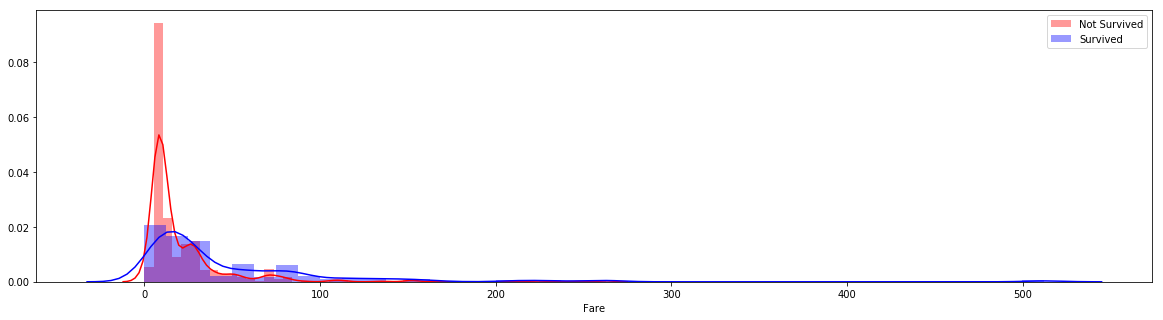

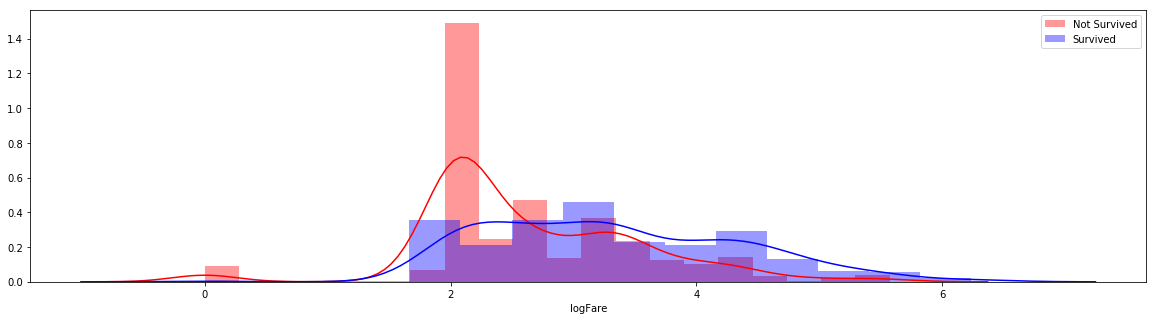

In [19]:
fig, ax = plt.subplots(figsize=(20, 5))
g = sns.distplot(data_c["Fare"][data_c["Survived"] == 0], color="r")
g = sns.distplot(data_c["Fare"][data_c["Survived"] == 1], color="b")
g = g.legend(["Not Survived","Survived"])

for dataset in data_all:
    dataset['logFare'] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
    
fig, ax = plt.subplots(figsize=(20, 5))
g = sns.distplot(data_c["logFare"][data_c["Survived"] == 0], color="r")
g = sns.distplot(data_c["logFare"][data_c["Survived"] == 1], color="b")
g = g.legend(["Not Survived","Survived"])

### Other variables

In [20]:
#Here we fill other NAs and drop useless columns
for dataset in data_all:
    dataset['Embarked'].fillna('S', inplace=True)
    
    dataset['Fare'].fillna(dataset['Fare'].mean(), inplace=True)
    
    dataset['Cabin'].fillna('U',inplace=True)
    dataset['Cabin'] = dataset['Cabin'].map(lambda x: x[0])
    
    dataset['Sex'] = dataset['Sex'].map({'male' : 1, 'female' : 0})
    
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0

    #dataset['FareBin'] = pd.qcut(dataset['Fare'], 5)
    #dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)
    
    drop_column = ['PassengerId','Name', 'Ticket']
    dataset.drop(drop_column, axis=1, inplace = True)

In [21]:
print(data_c.isnull().sum())
print("-"*10)
print(data_val.isnull().sum())
data_c.head(10)

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Cabin         0
Embarked      0
Title         0
logFare       0
FamilySize    0
IsAlone       0
dtype: int64
----------
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Cabin         0
Embarked      0
Title         0
logFare       0
FamilySize    0
IsAlone       0
dtype: int64


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,logFare,FamilySize,IsAlone
0,0,3,1,22.0,1,0,7.2500,U,S,Mr,1.981001,2,0
1,1,1,0,38.0,1,0,71.2833,C,C,Mrs,4.266662,2,0
2,1,3,0,26.0,0,0,7.9250,U,S,Miss,2.070022,1,1
3,1,1,0,35.0,1,0,53.1000,C,S,Mrs,3.972177,2,0
4,0,3,1,35.0,0,0,8.0500,U,S,Mr,2.085672,1,1
5,0,3,1,26.0,0,0,8.4583,U,Q,Mr,2.135148,1,1
6,0,1,1,54.0,0,0,51.8625,E,S,Mr,3.948596,1,1
7,0,3,1,2.0,3,1,21.0750,U,S,Master,3.048088,5,0
8,1,3,0,27.0,0,2,11.1333,U,S,Mrs,2.409941,3,0
9,1,2,0,14.0,1,0,30.0708,U,C,Mrs,3.403555,2,0


## Some useful visuals

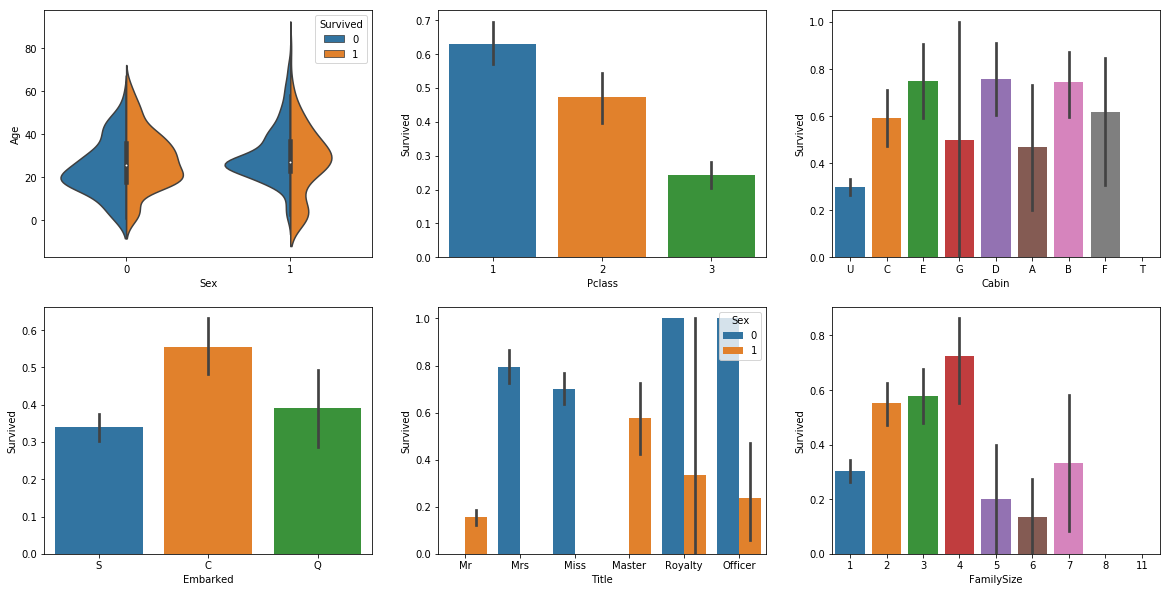

In [22]:
fig, ax = plt.subplots(2,3,figsize=(20,10))
sns.violinplot(x="Sex",y="Age",hue='Survived',data=data_c,split=True,ax=ax[0,0])
sns.barplot(x="Pclass",y="Survived",data=data_c,ax=ax[0,1])
sns.barplot(x="Cabin",y="Survived",data=data_c,ax=ax[0,2])
sns.barplot(x="Embarked",y="Survived",data=data_c,ax=ax[1,0])
sns.barplot(x="Title",y="Survived",hue="Sex",data=data_c,ax=ax[1,1])
sns.barplot(x="FamilySize",y="Survived",data=data_c,ax=ax[1,2])

In [30]:
#for dataset in data_all:    
#    dataset['Embarked'] = dataset['Embarked'].map({'S' : 0, 'C' : 1, 'Q' :2})
#    dataset['Cabin'] = dataset['Cabin'].map({'U':0,'C':1,'E':2,'G':3,'D':4,'A':5,'B':6,'F':7,'T':8})
#    dataset['Title'] = dataset['Title'].map({'Mr':0,'Mrs':1,'Miss':2,'Master':3,'Royalty':4,'Officer':5})
    
def categorize_row(dataset,row_name):
    dataset_c = dataset.copy(deep=True)
    dummies = pd.get_dummies(dataset_c[row_name], prefix=row_name)
    dataset_c = pd.concat([dataset_c, dummies], axis=1)
    dataset_c.drop(row_name, axis=1, inplace=True)
    return dataset_c

In [31]:
data_c.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,logFare,FamilySize,IsAlone
0,0,3,1,22.0,1,0,7.2500,U,S,Mr,1.981001,2,0
1,1,1,0,38.0,1,0,71.2833,C,C,Mrs,4.266662,2,0
2,1,3,0,26.0,0,0,7.9250,U,S,Miss,2.070022,1,1
3,1,1,0,35.0,1,0,53.1000,C,S,Mrs,3.972177,2,0
4,0,3,1,35.0,0,0,8.0500,U,S,Mr,2.085672,1,1
5,0,3,1,26.0,0,0,8.4583,U,Q,Mr,2.135148,1,1
6,0,1,1,54.0,0,0,51.8625,E,S,Mr,3.948596,1,1
7,0,3,1,2.0,3,1,21.0750,U,S,Master,3.048088,5,0
8,1,3,0,27.0,0,2,11.1333,U,S,Mrs,2.409941,3,0
9,1,2,0,14.0,1,0,30.0708,U,C,Mrs,3.403555,2,0
